In [0]:
!pip install nltk # install nltk onto databricks
import nltk
nltk.download('stopwords') #add stopwords

import os.path
import sklearn
from pyspark.sql.types import *
from nltk.stem import LancasterStemmer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from pyspark.sql.functions import concat_ws, udf



You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#list of words to filter out of statements
stop_words = set(stopwords.words('english'))
# stemmer to turn words into their roots
lan=LancasterStemmer()

@udf
def clean(text):
    print(text)
    text = text.lower()#convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+|ftp\S+", '', text, flags=re.MULTILINE)#remove links
    text = re.sub('[^\w ]','',text)#remove whitespaces 
    text = text.translate(str.maketrans('', '', string.punctuation))#remove punctuation 
    tweet_tokens = word_tokenize(text,preserve_line=True)#tokenize words
    filtered_words = [lan.stem(w) for w in tweet_tokens if not w in stop_words]#stemming

    return ' '.join(filtered_words)

In [0]:
reviewsDF = spark.read.csv('/FileStore/tables/reviews-2.csv', header = True) #read in dataset
reviewsDF = reviewsDF.select('overall',concat_ws(' ',reviewsDF['summary'],reviewsDF['reviewText']).alias("text"))#combine summary and reviewText
reviewsDF = reviewsDF.withColumn('text', clean(reviewsDF['text'])) #clean text data
reviewsDF.show(5)

+-------+--------------------+
|overall|                text|
+-------+--------------------+
|      5|fiv star advert r...|
|      5|good fac lik od f...|
|      1|smel aw bought sm...|
|      5|tru noth lik aqu ...|
|      5|bvlgari shampoo e...|
+-------+--------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
#tokenize words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(reviewsDF)
#convert to vector
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)
#copute IDF of rawFeatures
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
#add to RDD
reviewsRDD = rescaledData.select("overall", "features").rdd
reviewsRDD.take(1)

Out[4]: [Row(overall='5', features=SparseVector(20, {0: 0.5772, 4: 0.7366, 10: 0.3344, 15: 0.4318, 19: 0.6349}))]

In [0]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint


transformedRDD = reviewsRDD.map(lambda row: LabeledPoint(row['overall'], row['features'].toArray()))
#split data (60% train 20% validation 20% test)
splits = [0.6, 0.2, 0.2]
training_data, validation_data, test_data = transformedRDD.randomSplit(splits, 0)

#cache to keep in mem
training_data.cache()
validation_data.cache()
test_data.cache()

print("Number of training set rows: %d" % training_data.count())
print("Number of validation set rows: %d" % validation_data.count())
print("Number of test set rows: %d" % test_data.count())

Number of training set rows: 3119
Number of validation set rows: 1077
Number of test set rows: 1073


In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

def evaluateMetrics(metrics, m_id):
    print()
    print("--------------------------------------------------------------")    
    print("Performance Metrics for Model " + str(m_id))
    print()
    print("Accuracy: %.2f" % (metrics.accuracy))
    for i in range(1, 6):
        print("Label " + str(i))
        print("Precision: %.2f" % (metrics.precision(i)))
        print("Recall: %.2f" % (metrics.recall(i)))
       # print("F-Score: %.2f%%" % (metrics.fMeasure(i,beta=1.0) * 100))
        print()

In [0]:
from pyspark.mllib.tree import RandomForest
#evaluate which parameters work best for model 
model1 = RandomForest.trainClassifier(sc.parallelize(training_data.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=10, maxDepth=5)
model2 = RandomForest.trainClassifier(sc.parallelize(training_data.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=10, maxDepth=20)
model3 = RandomForest.trainClassifier(sc.parallelize(training_data.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=20, maxDepth=25)
model4 = RandomForest.trainClassifier(sc.parallelize(training_data.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=25, maxDepth=30)


Model accuracy: 89.47%
Model accuracy: 95.90%
Model accuracy: 95.99%
Model accuracy: 95.99%


In [0]:
#evaluate models using validation data
pred = model1.predict(validation_data.map(lambda x: x.features))
y_labels = validation_data.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 1)

pred = model2.predict(validation_data.map(lambda x: x.features))
y_labels = validation_data.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 2)

pred = model3.predict(validation_data.map(lambda x: x.features))
y_labels = validation_data.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 3)

pred = model4.predict(validation_data.map(lambda x: x.features))
y_labels = validation_data.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 4)


--------------------------------------------------------------
Performance Metrics for Model 1

Accuracy: 0.89
Label 1
Precision: 0.00
Recall: 0.00

Label 2
Precision: 0.00
Recall: 0.00

Label 3
Precision: 1.00
Recall: 0.04

Label 4
Precision: 1.00
Recall: 0.03

Label 5
Precision: 0.89
Recall: 1.00


--------------------------------------------------------------
Performance Metrics for Model 2

Accuracy: 0.96
Label 1
Precision: 1.00
Recall: 0.74

Label 2
Precision: 1.00
Recall: 0.40

Label 3
Precision: 0.93
Recall: 0.56

Label 4
Precision: 0.91
Recall: 0.64

Label 5
Precision: 0.96
Recall: 1.00


--------------------------------------------------------------
Performance Metrics for Model 3

Accuracy: 0.96
Label 1
Precision: 1.00
Recall: 0.74

Label 2
Precision: 1.00
Recall: 0.50

Label 3
Precision: 0.94
Recall: 0.60

Label 4
Precision: 0.95
Recall: 0.62

Label 5
Precision: 0.96
Recall: 1.00


--------------------------------------------------------------
Performance Metrics for Model 

In [0]:
from pyspark.mllib.tree import RandomForest
#Train RandomForest Model
#using parameters with best results from above
#classes represent star ratings
#set number of trees for eval to 10 and set maxDepth to 20
#set random seed to 0 so results can be replicated
model = RandomForest.trainClassifier(sc.parallelize(training_data.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=25, maxDepth=30, seed=0)

#evaluate models using test data
pred = model.predict(test_data.map(lambda x: x.features))
y_labels = test_data.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
testMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 4)


--------------------------------------------------------------
Performance Metrics for Model 4

Accuracy: 0.97
Label 1
Precision: 1.00
Recall: 0.88

Label 2
Precision: 1.00
Recall: 0.94

Label 3
Precision: 1.00
Recall: 0.63

Label 4
Precision: 0.93
Recall: 0.69

Label 5
Precision: 0.97
Recall: 1.00



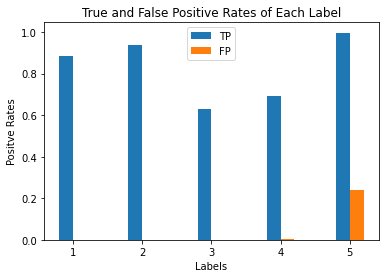

In [0]:
#graph results
import numpy as np
import matplotlib.pyplot as plt
def positiveRates(metric, type):
    list = []
    for i in range(1,6):
        if type == 1:
            list.append(metric.truePositiveRate(float(i)))
        if type == 2:
            list.append(metric.falsePositiveRate(float(i)))            
    return list

truePos = positiveRates(testMetrics, 1)
falsePos = positiveRates(testMetrics, 2)

X = ['1', '2', '3', '4', '5']
X_axis = np.arange(5)

plt.bar(X_axis - 0.1, truePos, 0.2, label = 'TP')
plt.bar(X_axis + 0.1, falsePos, 0.2, label = 'FP')

plt.xticks(X_axis, X)
plt.xlabel("Labels")
plt.ylabel("Positve Rates")
plt.title("True and False Positive Rates of Each Label")
plt.legend()
plt.show()